# Langmuir isotherm predictions improved by modeling relative life with Gaussian process

---

## Introduction

The Langmuir isotherm model assumes constant relative life.[$^{[1]}$](#1) The Toth model provides an empirical improvement and was found to fit $q(T, p)$ measurements for Zeolite 13X the best.[$^{[2]}$](#2) However, applying a Gaussian regression (GP) to the relative life improved the Langmuir isotherm model further.

## Method

The nomenclature was taken from [[1]](#1) except for $\mathbf{GP}$ and $\Delta$.

The GP model $\mathbf{GP}$ will be trained on $\Delta$ as a function of inverse temperature $T$ and natural logarithim of pressure $p$.

$\begin{equation}\tag{1} \mathbf{GP} = \{\Delta\ |\ T^{-1},\ \ln(p)\} \end{equation}$

$\begin{equation}\tag{2} \Delta = \ln(\sigma_1) \end{equation}$

$\begin{equation}\tag{3} \sigma_1 = \frac{q}{\mu(q_{max}-q)} \end{equation}$

$\begin{equation}\tag{4} \mu = \frac{p}{\sqrt{2 \pi M R T}} \end{equation}$

$\begin{equation}\tag{5} q_{max} = b \end{equation}$

Then, to make predictions $q_{cal}$ from $\mathbf{GP}$,

$\begin{equation}\tag{6} q_{cal} = \frac{\sigma_{1, cal} q_{max} \mu}{1 + \sigma_{1, cal} \mu} \end{equation}$

$\begin{equation}\tag{7} \sigma_{1, cal} = \exp(\mathbf{GP}) \end{equation}$

Note from Table 2 and Table 4 of [[2]](#2), respectively, experimental measurements $q(T, p)$ are saved as *data.txt* and Toth model parameters $(q_s, b, t)$ are saved as *toth.txt*. Values of $q_{max}$ are assumed from these $q_s$ values, although experimental or literature values may produce a more accurate model. 

From Equation 2 of [[2]](#2), the Toth model is as follows.

$\begin{equation}\tag{8} q = \frac{q_s P}{(b+P^t)^{1/t}} \end{equation}$

---

## Implementation

In [1]:
# -----------------------------------------------------------------------
# Local version of 'from FoKL import ...':
import os
import sys
dir = os.path.abspath(os.path.dirname(__file__))  # directory of script
sys.path.append(dir)
sys.path.append(os.path.join(dir, '..', '..', '..'))  # package directory
from src.FoKL import FoKLRoutines
from src.FoKL.fokl_to_pyomo import fokl_to_pyomo
# -----------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import pyomo.environ as pyo
from pyomo.environ import *


M = 0.0440095  # molecular weight of CO2, kg/mol
R = 8.31446261815324  # universal gas constant, J/(K*mol)

Loading and parsing data:

In [2]:
# Experimental measurements:

data = np.loadtxt(os.path.join('data', 'data.txt'), skiprows=2)  # experimental measurements q(T, p)

T = data[:, 0]  # K
p_kPa = data[:, 1]  # kPa
p = p_kPa * 1e3  # kPa to Pa
q = data[:, 2]  # mol/kg

T_const = np.where(T[:-1] != T[1:])[0]  # indices where experiment ends (i.e., where next temperature changes)
T_const = np.insert(T_const + 1, [0, len(T_const)], [0, len(T)])  # indices where experiments begin (including "next" experiment enabling 'data[T_const[i]:T_const[i + 1], :]')
n = len(T_const) - 1  # number of experiments
nd = np.array(list(T_const[i + 1] - T_const[i] for i in range(n)))  # number of datapoints in each experiment

# Toth model:

toth = np.loadtxt(os.path.join('data', 'toth.txt'), skiprows=2)  # model parameters (qs, b, t)

qs = np.repeat(toth[:, 1], nd)  # mol/kg, 'np.repeat(x, nd)' for repeating experiments' single values at each datapoint
b = np.repeat(toth[:, 2], nd)  # kPa
t = np.repeat(toth[:, 3], nd)

Defining equations:

In [3]:
def eq2(sigma1):
    """Delta"""
    return np.log(sigma1)

def eq3(q, mu, qmax):
    """sigma1"""
    return q / mu / (qmax - q)

def eq4(p, M, R, T):
    """mu"""
    return p / np.sqrt(2 * np.pi * M * R * T)

def eq6(sigma1, qmax, mu):
    """qcal"""
    return sigma1 * qmax * mu / (1 + sigma1 * mu)

def eq8(qs, b, t, p_kPa):
    """qcal_Toth, where p is in kPa. Equation 2 of [2]."""
    return qs * p_kPa / (b + p_kPa ** t) ** (1 / t)

Calculating training set $\{\Delta\ |\ T^{-1},\ \ln(p)\}$:

In [4]:
mu = eq4(p, M, R, T)
qmax = qs
sigma1 = eq3(q, mu, qmax)
Delta = eq2(sigma1)

inv_T = 1 / T
ln_p = np.log(p)

Training $\mathbf{GP}$:

In [5]:
GP = FoKLRoutines.FoKL(kernel=1, tolerance=1)
_ = GP.fit([inv_T, ln_p], Delta, clean=True)

/home/jacobpatrick/FoKL-GPy/docs/_dev/langmuir_isotherm/../../../src/FoKL/FoKLRoutines_dev.py:300: UserWarning: 'inputs' was transposed. Ignore if more datapoints than input variables, else set 'AutoTranspose=False' to disable.
  warnings.warn("'inputs' was transposed. Ignore if more datapoints than input variables, else set "


[1, -384.15314356452586]
[2, -596.4859900152487]
[2, -693.4041573239342]
[3, -710.2677235477411]
[3, -710.2677235477411]


Checking validation plot of each experiment:

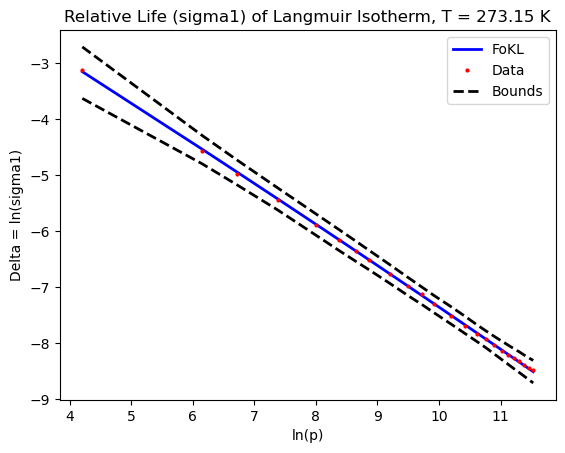

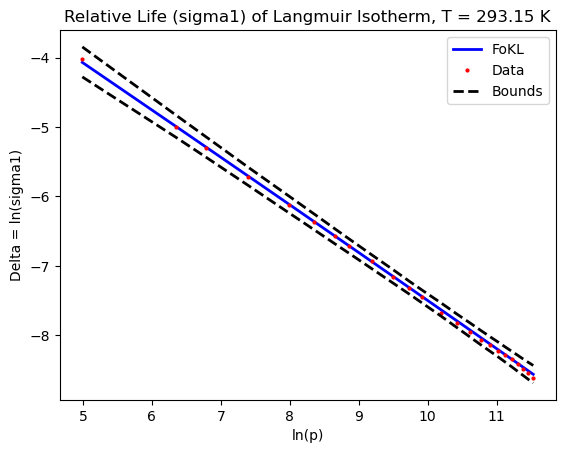

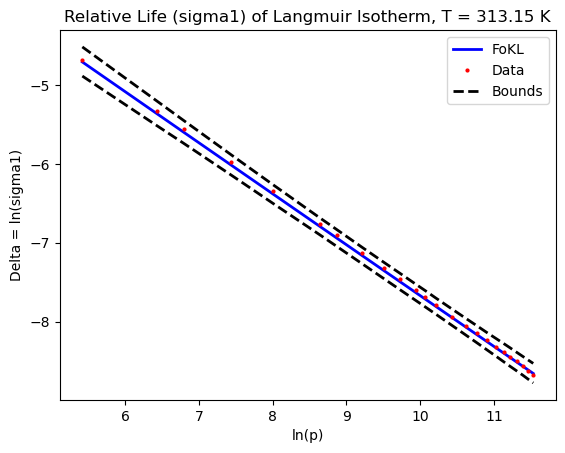

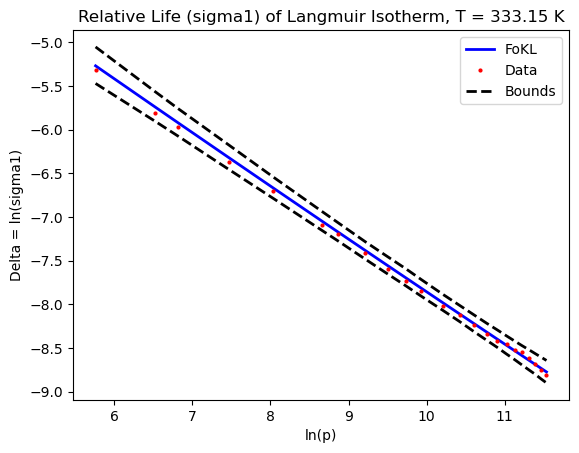

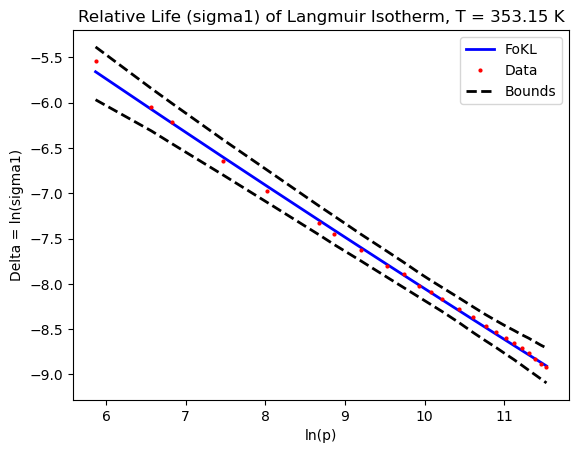

In [6]:
for i in range(n):  # for constant temperature
    title_i = f"Relative Life (sigma1) of Langmuir Isotherm, T = {np.round(T[T_const[i]], 2)} K"
    j, k = T_const[i], T_const[i + 1]
    inputs_i, data_i = GP.inputs[j:k, :], GP.data[j:k]
    GP.coverage3(inputs=inputs_i, data=data_i, title=title_i, plot=True, xaxis=1, xlabel='ln(p)', ylabel='Delta = ln(sigma1)')

Calculate $q_{cal}$ predictions for comparison:

In [7]:
Delta_cal = GP.evaluate()
sigma1_cal = np.exp(Delta_cal)
qcal = eq6(sigma1_cal, qmax, mu)  # GP

qcal_Toth = eq8(qs, b, t, p_kPa)  # Toth

Plotting data, GP model, and Toth model for comparison:

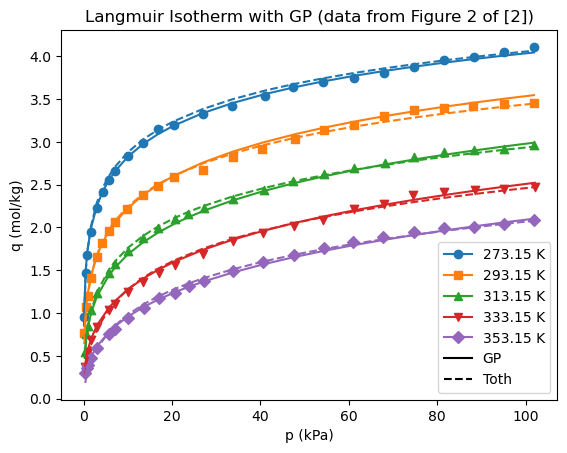

In [8]:
# Define styles and legend elements:

colors = mcolors.TABLEAU_COLORS  # dictionary of all colors
colors = list(colors.values())[:n]  # first 'n' colors, one per experiment

markers = ['o', 's', '^', 'v', 'D']
labels = list(f"{np.round(T[T_const[i]], 2)} K" for i in range(n))  # temperatures for legend

legend_elements = list(Line2D([0], [0], marker=markers[c], color=colors[c], label=labels[c]) for c in range(n)) + [Line2D([0], [0], ls='-', color='k', label='GP'), Line2D([0], [0], ls='--', color='k', label='Toth')]

# Plot:

fig, ax = plt.subplots()
for i in range(n):
    j = T_const[i]
    k = T_const[i + 1]

    plt.scatter(p_kPa[j:k], q[j:k], color=colors[i], marker=markers[i])  # experimental measurements
    plt.plot(p_kPa[j:k], qcal[j:k], '-', color=colors[i])  # GP model
    plt.plot(p_kPa[j:k], qcal_Toth[j:k], '--', color=colors[i])  # Toth model

ax.set_xlabel('p (kPa)')
ax.set_ylabel('q (mol/kg)')
ax.set_title('Langmuir Isotherm with GP (data from Figure 2 of [2])')
ax.legend(handles=legend_elements, loc='lower right')

Converting to Pyomo for any optimization problem requiring $q(T, p)$:

In [9]:
draws = 4
m = GP.to_pyomo(['inv_T', 'ln_p'], 'Delta', draws)
m.pprint()

3 Set Declarations
    GP0_j : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    2 : {0, 1}
    GP0_k : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    6 : {0, 1, 2, 3, 4, 5}
    GP0_scenarios : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    4 : {0, 1, 2, 3}

6 Var Declarations
    Delta : Size=4, Index=GP0_scenarios
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :  None :  None :  None : False :  True :  Reals
          1 :  None :  None :  None : False :  True :  Reals
          2 :  None :  None :  None : False :  True :  Reals
          3 :  None :  None :  None : False :  True :  Reals
    GP0_b : Size=24, Index=GP0_scenarios*GP0_k
        Key    : Lower : Value                : Upper : Fixed : Stale : Domain
        (0, 0) :  None :   -6.28964

Set up Pyomo objective and solver:

In [10]:
# NOTE: - Use 'm.VARNAME.index_set()' if unsure which GP# the variable is indexed by.
#       - ... for i in range(draws) == ... in m.GP0_scenarios ... == in m.Delta.index_set()
#       - Also, draws == len(m.Delta).

m.Delta_avg = Var(within=Reals)
m.Delta_avg_eq = Constraint(expr=m.Delta_avg == sum(m.Delta[i] for i in m.Delta.index_set()) / len(m.Delta))

m.stdev = Var(within=NonNegativeReals)
m.stdev_eq = Constraint(expr=m.stdev == sqrt(sum(m.Delta[i] - m.Delta_avg for i in m.Delta.index_set()) / len(m.Delta)))

m.obj = pyo.Objective(expr=m.stdev, sense=minimize)

solver = pyo.SolverFactory('multistart')
local_solver = 'ipopt'

Checking Pyomo solutions:

In [11]:
print(sys.path)

Delta_Pyomo = []
id_tot = -1
for i in range(n):  # experiment
    j = T_const[i]
    k = T_const[i + 1]

    m.T = T[j]
    
    for id in range(nd[i]):  # datapoint
        id_tot += 1
        
        m.p = p[id_tot]

        results = solver.solve(m, solver=local_solver)

        Delta_Pyomo.append(pyo.value(m.Delta))
        print(f"Delta_Pyomo = {Delta_Pyomo[id_tot]}")

['/usr/lib/python312.zip', '/usr/lib/python3.12', '/usr/lib/python3.12/lib-dynload', '', '/home/jacobpatrick/.local/lib/python3.12/site-packages', '/usr/local/lib/python3.12/dist-packages', '/usr/lib/python3/dist-packages', '../../..']
ERROR: Solver (ipopt) returned non-zero return code (127)
ERROR: Solver log: /usr/local/bin/ipopt: error while loading shared libraries:
libipoptamplinterface.so.3: cannot open shared object file: No such file or
directory


ApplicationError: Solver (ipopt) did not exit normally